In [2]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [3]:
df = pd.read_csv("/home/efe/Downloads/bank-additional-full.csv",delimiter=";")

In [4]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [5]:
X = df.drop('y', axis=1)  # Drop the target column to get the features
y = df['y']

In [6]:
def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit


def check_outlier(dataframe, col_name, q1=0.25, q3=0.75):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name, q1, q3)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False


def grab_outliers(dataframe, col_name, index=False):
    low, up = outlier_thresholds(dataframe, col_name)
    if dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].shape[0] > 10:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].head())
    else:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))])

    if index:
        outlier_index = dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].index
        return outlier_index


def remove_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    df_without_outliers = dataframe[~((dataframe[col_name] < low_limit) | (dataframe[col_name] > up_limit))]
    return df_without_outliers


def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")
    if na_name:
        return na_columns


def missing_vs_target(dataframe, target, na_columns):
    temp_df = dataframe.copy()
    for col in na_columns:
        temp_df[col + '_NA_FLAG'] = np.where(temp_df[col].isnull(), 1, 0)
    na_flags = temp_df.loc[:, temp_df.columns.str.contains("_NA_")].columns
    for col in na_flags:
        print(pd.DataFrame({"TARGET_MEAN": temp_df.groupby(col)[target].mean(),
                            "Count": temp_df.groupby(col)[target].count()}), end="\n\n\n")


def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe



def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe


def rare_analyser(dataframe, target, cat_cols):
    for col in cat_cols:
        print(col, ":", len(dataframe[col].value_counts()))
        print(pd.DataFrame({"COUNT": dataframe[col].value_counts(),
                            "RATIO": dataframe[col].value_counts() / len(dataframe),
                            "TARGET_MEAN": dataframe.groupby(col)[target].mean()}), end="\n\n\n")


def rare_encoder(dataframe, rare_perc, cat_cols):
    # sadece categorik değil bütün cat_cols listesinin rare durumunu inceleyecek şekilde güncellendi.

    # burada bir güncelleme daha var.
    # 1'den fazla rare varsa düzeltme yap. durumu göz önünde bulunduruldu.
    # rare sınıf sorgsu 0.01'e göre yapıldıktan sonra gelen true'ların sum'ı alınıyor.
    # eğer 1'den büyük ise rare cols listesine alınıyor.

    rare_columns = [col for col in cat_cols if (dataframe[col].value_counts() / len(dataframe) < 0.01).sum() > 1]

    for col in rare_columns:
        tmp = dataframe[col].value_counts() / len(dataframe)
        rare_labels = tmp[tmp < rare_perc].index
        dataframe[col] = np.where(dataframe[col].isin(rare_labels), 'Rare', dataframe[col])

    return dataframe
def check_df(dataframe, head=5):
 
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)


def cat_summary(dataframe, col_name, plot=False):
   
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show()


def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show()



def grab_col_names(dataframe, cat_th=10, car_th=20):
    """

    Gives the names of categorical, numeric and categorical but cardinal variables in the dataset.

    Note: Categorical variables with numeric appearance are also included in categorical variables.

    Parameters
    ------
    dataframe: dataframe
    Dataframe from which variable names are to be taken
    cat_th: int, optional
    Class threshold value for numeric but categorical variables
    car_th: int, optinal
    Class threshold value for categorical but cardinal variables

    Returns
    ------
    cat_cols: list
    Categorical variable list
    num_cols: list
    Numeric variable list
    cat_but_car: list
    Cardinal variable list with categorical appearance

    Examples
    ------
    import seaborn as sns
    df = sns.load_dataset("iris")
    print(grab_col_names(df))

    Notes
    ------
    cat_cols + num_cols + cat_but_car = total number of variables
    num_but_cat is inside cat_cols.
    The sum of the 3 lists returned is equal to the total number of variables: cat_cols + num_cols + cat_but_car = number of variables

    """


    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    # print(f"Observations: {dataframe.shape[0]}")
    # print(f"Variables: {dataframe.shape[1]}")
    # print(f'cat_cols: {len(cat_cols)}')
    # print(f'num_cols: {len(num_cols)}')
    # print(f'cat_but_car: {len(cat_but_car)}')
    # print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car


def target_summary_with_cat(dataframe, target, categorical_col):
    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean()}), end="\n\n\n")


def target_summary_with_cat_extended(dataframe, target, categorical_col):
    """

Groups the Target column in the dataset according to the entered categorical column and prints the results
- mean
- count
- ratio

Parameters
------
dataframe: dataframe
Dataframe containing the Target and Categorical columns
target: str
Target variable to get the result
categorical_col: str
Categorical column to be grouped

Returns
------
None

"""

    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean(),
                        "TARGET_CCOUNT": dataframe.groupby(categorical_col)[target].count(),
                        "RATIO": 100 * dataframe[categorical_col].value_counts() / len(dataframe)}), end="\n\n\n")


def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")



def high_correlated_cols(dataframe, plot=False, corr_th=0.90):
    corr = dataframe.corr()
    cor_matrix = corr.abs()
    upper_triangle_matrix = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(np.bool))
    drop_list = [col for col in upper_triangle_matrix.columns if any(upper_triangle_matrix[col] > corr_th)]
    if plot:
        import seaborn as sns
        import matplotlib.pyplot as plt
        sns.set(rc={'figure.figsize': (15, 15)})
        sns.heatmap(corr, cmap="RdBu")
        plt.show()
    return drop_list

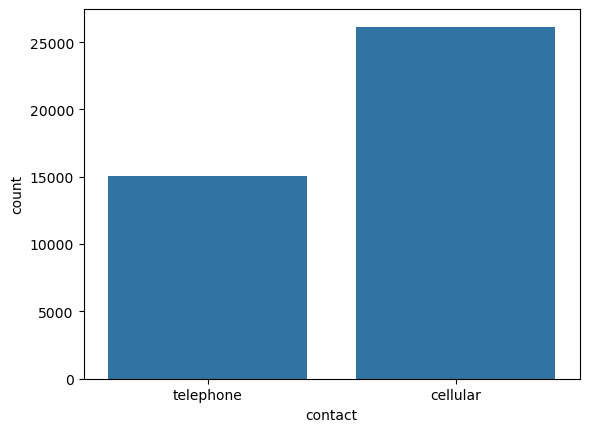

In [7]:
sns.countplot(x = "contact", data = df)
plt.show()

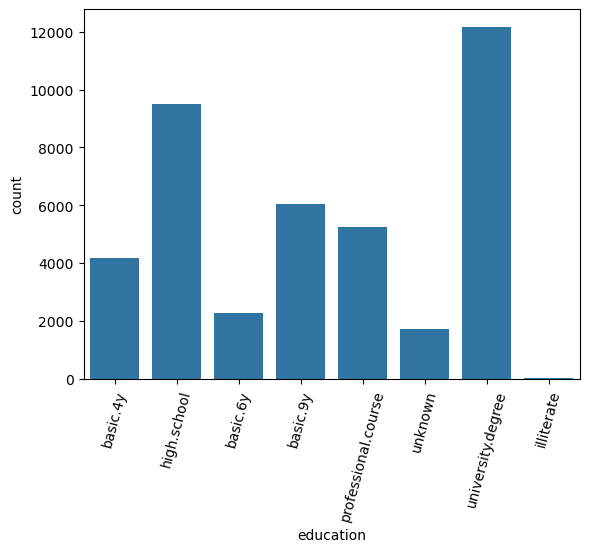

In [8]:
sns.countplot(x = "education", data = df)
plt.xticks(rotation=75)
plt.show()

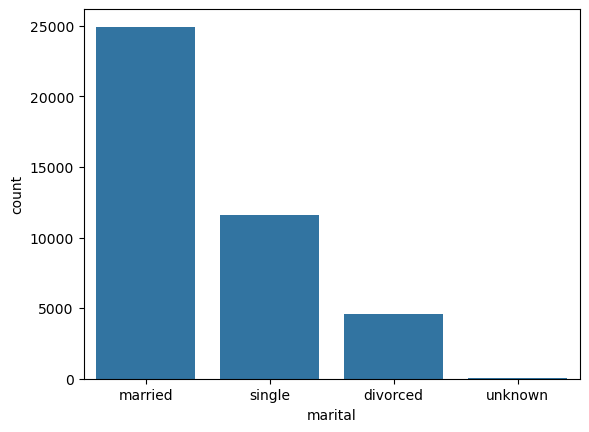

In [9]:
sns.countplot(x= "marital", data =df)
plt.show()

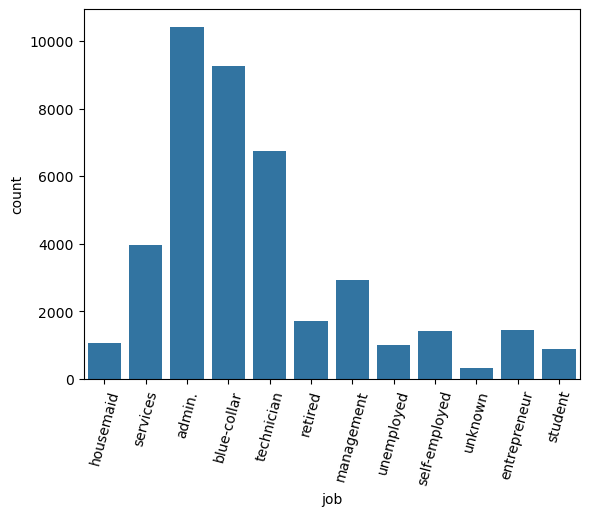

In [10]:
sns.countplot(x = "job", data = df)
plt.xticks(rotation=75)
plt.show()


In [11]:
df.corr(numeric_only=True)

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
age,1.000000,-0.000866,0.004594,-0.034369,0.024365,-0.000371,0.000857,0.129372,0.010767,-0.017725
duration,-0.000866,1.000000,-0.071699,-0.047577,0.020640,-0.027968,0.005312,-0.008173,-0.032897,-0.044703
campaign,0.004594,-0.071699,1.000000,0.052584,-0.079141,0.150754,0.127836,-0.013733,0.135133,0.144095
pdays,-0.034369,-0.047577,0.052584,1.000000,-0.587514,0.271004,0.078889,-0.091342,0.296899,0.372605
previous,0.024365,0.020640,-0.079141,-0.587514,1.000000,-0.420489,-0.203130,-0.050936,-0.454494,-0.501333
emp.var.rate,-0.000371,-0.027968,0.150754,0.271004,-0.420489,1.000000,0.775334,0.196041,0.972245,0.906970
cons.price.idx,0.000857,0.005312,0.127836,0.078889,-0.203130,0.775334,1.000000,0.058986,0.688230,0.522034
cons.conf.idx,0.129372,-0.008173,-0.013733,-0.091342,-0.050936,0.196041,0.058986,1.000000,0.277686,0.100513
euribor3m,0.010767,-0.032897,0.135133,0.296899,-0.454494,0.972245,0.688230,0.277686,1.000000,0.945154
nr.employed,-0.017725,-0.044703,0.144095,0.372605,-0.501333,0.906970,0.522034,0.100513,0.945154,1.000000


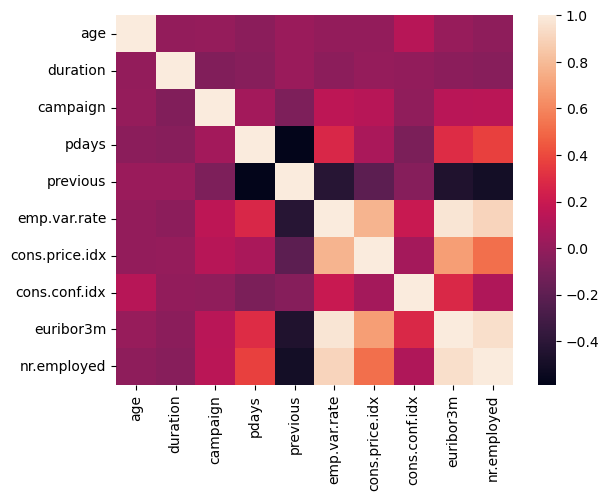

In [12]:
sns.heatmap(df.corr(numeric_only=True))
plt.show()

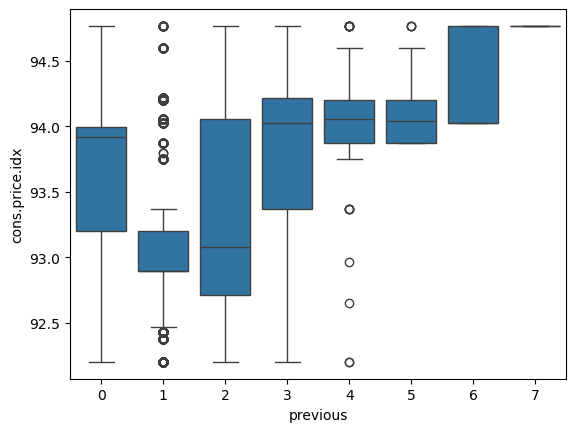

In [13]:
sns.boxplot(data = df,x="previous",y="cons.price.idx")
plt.show()

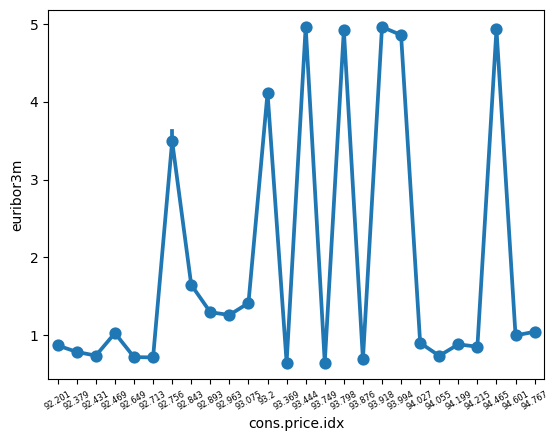

In [14]:
sns.pointplot(data = df,x="cons.price.idx",y="euribor3m")
plt.xticks(rotation=30,fontsize=6)
plt.show()

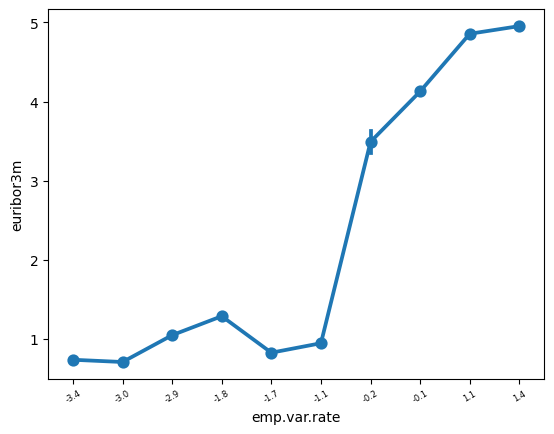

In [15]:
sns.pointplot(data = df,x="emp.var.rate",y="euribor3m")
plt.xticks(rotation=30,fontsize=6)
plt.show()

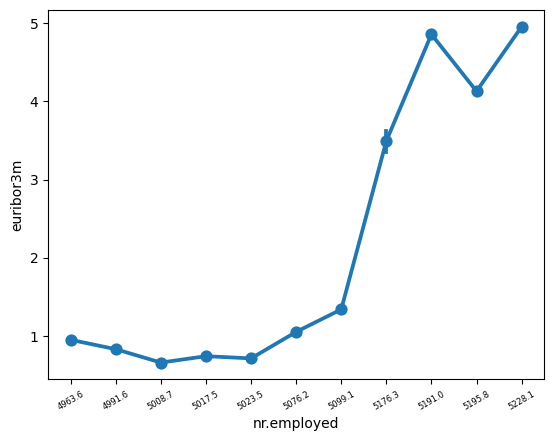

In [16]:
sns.pointplot(data = df,x="nr.employed",y="euribor3m")
plt.xticks(rotation=30,fontsize=6)
plt.show()

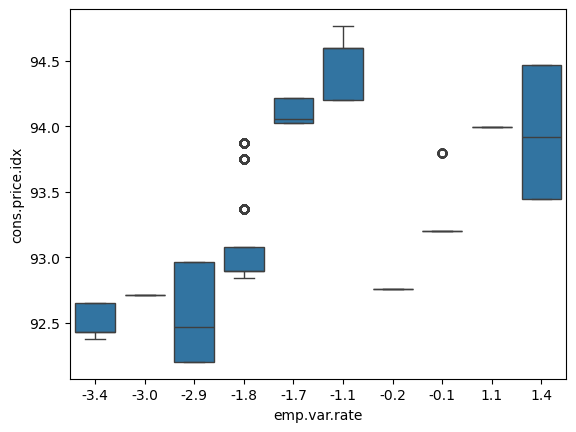

In [17]:
sns.boxplot(data = df, x = "emp.var.rate", y = "cons.price.idx")
plt.show()

In [18]:
grab_col_names(df)

(['job',
  'marital',
  'education',
  'default',
  'housing',
  'loan',
  'contact',
  'month',
  'day_of_week',
  'poutcome',
  'y',
  'previous'],
 ['age',
  'duration',
  'campaign',
  'pdays',
  'emp.var.rate',
  'cons.price.idx',
  'cons.conf.idx',
  'euribor3m',
  'nr.employed'],
 [])

In [19]:
num_summary(df,["age","duration","campaign","pdays","campaign","emp.var.rate","cons.price.idx","cons.conf.idx","euribor3m","nr.employed"])

                  count         mean         std       min        5%  \
age             41188.0    40.024060   10.421250    17.000    26.000   
duration        41188.0   258.285010  259.279249     0.000    36.000   
campaign        41188.0     2.567593    2.770014     1.000     1.000   
pdays           41188.0   962.475454  186.910907     0.000   999.000   
campaign        41188.0     2.567593    2.770014     1.000     1.000   
emp.var.rate    41188.0     0.081886    1.570960    -3.400    -2.900   
cons.price.idx  41188.0    93.575664    0.578840    92.201    92.713   
cons.conf.idx   41188.0   -40.502600    4.628198   -50.800   -47.100   
euribor3m       41188.0     3.621291    1.734447     0.634     0.797   
nr.employed     41188.0  5167.035911   72.251528  4963.600  5017.500   

                     10%       20%      30%       40%       50%       60%  \
age               28.000    31.000    33.00    35.000    38.000    41.000   
duration          59.000    89.000   116.00   146.000

In [20]:
grab_outliers(df,col_name="duration")

    age           job   marital          education  default housing loan  \
37   52    technician   married           basic.9y       no     yes   no   
57   45      services   married        high.school  unknown     yes   no   
61   51   blue-collar   married           basic.9y       no     yes   no   
75   41   blue-collar  divorced           basic.4y  unknown     yes   no   
83   49  entrepreneur   married  university.degree  unknown     yes   no   

      contact month day_of_week  ...  campaign  pdays  previous     poutcome  \
37  telephone   may         mon  ...         1    999         0  nonexistent   
57  telephone   may         mon  ...         1    999         0  nonexistent   
61  telephone   may         mon  ...         1    999         0  nonexistent   
75  telephone   may         mon  ...         1    999         0  nonexistent   
83  telephone   may         mon  ...         1    999         0  nonexistent   

   emp.var.rate  cons.price.idx  cons.conf.idx  euribor3m  nr.

In [21]:
remove_outlier(df,"duration")

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,...,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


In [22]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')

In [23]:
df = pd.get_dummies(df)

In [24]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
scaler = StandardScaler()

In [25]:
df[["age","duration","campaign","pdays","emp.var.rate","cons.price.idx","cons.conf.idx","euribor3m","nr.employed"]] = scaler.fit_transform(df[["age","duration","campaign","pdays","emp.var.rate","cons.price.idx","cons.conf.idx","euribor3m","nr.employed"]])

In [26]:
df.head()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,...,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success,y_no,y_yes
0,1.533034,0.010471,-0.565922,0.195414,0,0.648092,0.722722,0.886447,0.71246,0.33168,...,False,True,False,False,False,False,True,False,True,False
1,1.628993,-0.421501,-0.565922,0.195414,0,0.648092,0.722722,0.886447,0.71246,0.33168,...,False,True,False,False,False,False,True,False,True,False
2,-0.290186,-0.124520,-0.565922,0.195414,0,0.648092,0.722722,0.886447,0.71246,0.33168,...,False,True,False,False,False,False,True,False,True,False
3,-0.002309,-0.413787,-0.565922,0.195414,0,0.648092,0.722722,0.886447,0.71246,0.33168,...,False,True,False,False,False,False,True,False,True,False
4,1.533034,0.187888,-0.565922,0.195414,0,0.648092,0.722722,0.886447,0.71246,0.33168,...,False,True,False,False,False,False,True,False,True,False


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 65 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   age                            41188 non-null  float64
 1   duration                       41188 non-null  float64
 2   campaign                       41188 non-null  float64
 3   pdays                          41188 non-null  float64
 4   previous                       41188 non-null  int64  
 5   emp.var.rate                   41188 non-null  float64
 6   cons.price.idx                 41188 non-null  float64
 7   cons.conf.idx                  41188 non-null  float64
 8   euribor3m                      41188 non-null  float64
 9   nr.employed                    41188 non-null  float64
 10  job_admin.                     41188 non-null  bool   
 11  job_blue-collar                41188 non-null  bool   
 12  job_entrepreneur               41188 non-null 

In [28]:
df.tail()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,...,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success,y_no,y_yes
41183,3.164336,0.292025,-0.565922,0.195414,0,-0.752343,2.058168,-2.224953,-1.495186,-2.815697,...,True,False,False,False,False,False,True,False,False,True
41184,0.573445,0.481012,-0.565922,0.195414,0,-0.752343,2.058168,-2.224953,-1.495186,-2.815697,...,True,False,False,False,False,False,True,False,True,False
41185,1.533034,-0.267225,-0.204909,0.195414,0,-0.752343,2.058168,-2.224953,-1.495186,-2.815697,...,True,False,False,False,False,False,True,False,True,False
41186,0.381527,0.708569,-0.565922,0.195414,0,-0.752343,2.058168,-2.224953,-1.495186,-2.815697,...,True,False,False,False,False,False,True,False,False,True
41187,3.260295,-0.074380,0.156105,0.195414,1,-0.752343,2.058168,-2.224953,-1.495186,-2.815697,...,True,False,False,False,False,True,False,False,True,False


In [37]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Assuming your DataFrame is named 'df' and the target variable is 'target'
# Replace 'target' with the actual column name of your target variable
df.drop('y_no', axis=1, inplace=True)
# Separate features and target
X = df.iloc[:, :-1]  # Features (all columns except the last one)
y = df['y_yes']     # Target variable

# Standardize the first 11 columns
scaler = StandardScaler()
X.iloc[:, :11] = scaler.fit_transform(X.iloc[:, :11])

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize and train the Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

/tmp/ipykernel_24701/1043671280.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.34949428 -0.34949428 -0.34949428 ... -0.34949428 -0.34949428
  1.67113606]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X.iloc[:, :11] = scaler.fit_transform(X.iloc[:, :11])
/tmp/ipykernel_24701/1043671280.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.58202282 -0.58202282 -0.58202282 ... -0.58202282 -0.58202282
 -0.58202282]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  X.iloc[:, :11] = scaler.fit_transform(X.iloc[:, :11])


Accuracy: 0.91


In [42]:
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/153.9 MB 4.7 MB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.0/199.0 MB 2.9 MB/s eta 0:00:00m eta 0:00:010:00:02


In [43]:
import xgboost as xgb
# Convert the dataset into DMatrix format, which is optimized for XGBoost
train_dmatrix = xgb.DMatrix(X_train, label=y_train)
test_dmatrix = xgb.DMatrix(X_test, label=y_test)

# Define parameters for the model
params = {
    'objective': 'multi:softmax',  # For classification (multi-class classification in this case)
    'num_class': 3,                # Number of classes (adjust for your dataset)
    'eval_metric': 'mlogloss',     # Evaluation metric
    'max_depth': 5,                # Max depth of trees
    'learning_rate': 0.1,          # Learning rate (step size)
    'silent': 1
}

# Train the model
xgb_model = xgb.train(params, train_dmatrix, num_boost_round=100, evals=[(test_dmatrix, 'eval')], early_stopping_rounds=10)

# Make predictions on the test set
y_pred = xgb_model.predict(test_dmatrix)

# Since we're using softmax (multi-class classification), we don't need to transform the probabilities
# If multi-class, predictions are the indices of the classes
y_pred_classes = y_pred.astype(int)

# Evaluate the model's accuracy
accuracy = accuracy_score(y_test, y_pred_classes)
print(f"Accuracy: {accuracy * 100:.2f}%")

[0]	eval-mlogloss:0.97955
[1]	eval-mlogloss:0.88078
[2]	eval-mlogloss:0.79737
[3]	eval-mlogloss:0.72613
[4]	eval-mlogloss:0.66472
[5]	eval-mlogloss:0.61141
[6]	eval-mlogloss:0.56489
[7]	eval-mlogloss:0.52418
[8]	eval-mlogloss:0.48823
[9]	eval-mlogloss:0.45649
[10]	eval-mlogloss:0.42822
[11]	eval-mlogloss:0.40319
[12]	eval-mlogloss:0.38080
[13]	eval-mlogloss:0.36061


/home/efe/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:43:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[14]	eval-mlogloss:0.34264
[15]	eval-mlogloss:0.32664
[16]	eval-mlogloss:0.31223
[17]	eval-mlogloss:0.29936
[18]	eval-mlogloss:0.28780
[19]	eval-mlogloss:0.27741
[20]	eval-mlogloss:0.26804
[21]	eval-mlogloss:0.25951
[22]	eval-mlogloss:0.25184
[23]	eval-mlogloss:0.24493
[24]	eval-mlogloss:0.23877
[25]	eval-mlogloss:0.23301
[26]	eval-mlogloss:0.22793
[27]	eval-mlogloss:0.22329
[28]	eval-mlogloss:0.21900
[29]	eval-mlogloss:0.21518
[30]	eval-mlogloss:0.21177
[31]	eval-mlogloss:0.20863
[32]	eval-mlogloss:0.20577
[33]	eval-mlogloss:0.20311
[34]	eval-mlogloss:0.20062
[35]	eval-mlogloss:0.19839
[36]	eval-mlogloss:0.19639
[37]	eval-mlogloss:0.19460
[38]	eval-mlogloss:0.19293
[39]	eval-mlogloss:0.19131
[40]	eval-mlogloss:0.18985
[41]	eval-mlogloss:0.18862
[42]	eval-mlogloss:0.18748
[43]	eval-mlogloss:0.18644
[44]	eval-mlogloss:0.18546
[45]	eval-mlogloss:0.18451
[46]	eval-mlogloss:0.18366
[47]	eval-mlogloss:0.18294
[48]	eval-mlogloss:0.18225
[49]	eval-mlogloss:0.18161
[50]	eval-mlogloss:0.18105
[

In [46]:
!pip install Logistic
from sklearn.linear_model import LogisticRegression
# Create and train the Logistic Regression model (Multiclass)
model = LogisticRegression(max_iter=200)  # Increasing max_iter if convergence is an issue
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model's accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

ERROR: Could not find a version that satisfies the requirement Logistic (from versions: none)
ERROR: No matching distribution found for Logistic
Accuracy: 91.23%
